In [30]:
import gc
import pickle
from time import time, sleep
import re
import typing as tp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# LODA DATA

In [2]:
WORKSPACE = "/home/akhmadjonov/workspace/SD_Task"
DATA_PATH = f"{WORKSPACE}/data/GTKY_final/processed"

In [3]:
train_df = pd.read_csv(f"{DATA_PATH}/train.tsv", sep='\t')
test_df = pd.read_csv(f"{DATA_PATH}/test.tsv", sep='\t')
val_df = pd.read_csv(f"{DATA_PATH}/valid.tsv", sep="\t")
train_df.head(10)

,dialogue_id,utterance,target
0,0,"hi , how are you doing ? i am getting ready to...",<subj> i <rel> like_activity <obj> chasing che...
1,0,you must be very fast . hunting is one of my f...,<subj> i <rel> like_activity <obj> hunting
2,0,i am ! for my hobby i like to do canning or so...,<subj> i <rel> like_activity <obj> whittling
3,0,i also remodel homes when i am not out bow hun...,<subj> i <rel> like_activity <obj> hunting; <s...
4,0,that is neat . when i was in high school i pla...,<subj> i <rel> has_ability <obj> 6 100 meter dash
5,0,that is awesome . do you have a favorite seaso...,<none>
6,0,i do not . but i do have a favorite meat since...,<subj> i <rel> other <obj> carnivore
7,0,what is your favorite meat to eat ?,<none>
8,0,i would have to say its prime rib . do you hav...,<none>
9,0,i like chicken or macaroni and cheese .,<none>


In [4]:
train_df.dtypes

dialogue_id     int64
utterance      object
target         object
dtype: object

In [5]:
gc.collect()

0

# EDA

## Average, max, median triplet count per utterance

In [6]:
a = "<subj> i <rel> like_activity <obj> chasing che"
a.split(";")

['<subj> i <rel> like_activity <obj> chasing che']

In [6]:
def process_target(target_str: str) -> int:
    if re.match(r"<none>", target_str):
        return 0
    trg_splitted = target_str.split(";")
    return len(trg_splitted)

def get_triplet_count(data_df: pd.DataFrame) -> pd.Series:
    return data_df["target"].apply(process_target)

In [24]:
train_df.shape[0], test_df.shape[0], val_df.shape[0]

(131424, 15008, 15586)

In [7]:
np.mean(get_triplet_count(train_df)), np.mean(get_triplet_count(test_df)), np.mean(get_triplet_count(val_df))

(0.6133430728025323, 0.6061433901918977, 0.6287052482997562)

In [8]:
np.max(get_triplet_count(train_df)), np.max(get_triplet_count(test_df)), np.max(get_triplet_count(val_df))

(6, 5, 5)

In [9]:
np.median(get_triplet_count(train_df)), np.median(get_triplet_count(test_df)), np.median(get_triplet_count(val_df))

(0.0, 0.0, 1.0)

## Per utterance triplet count distribution

In [20]:
def plot_triplet_cnt(data_df: pd.DataFrame, title: str):
    triplet_cnt = get_triplet_count(data_df).to_numpy()
    plt.figure(figsize=(10, 4))
    sns.histplot(data=triplet_cnt, stat="percent")
    plt.title(label=title)
    plt.xlabel("количество триплов в реплике")
    plt.ylabel("процент")
    plt.show()

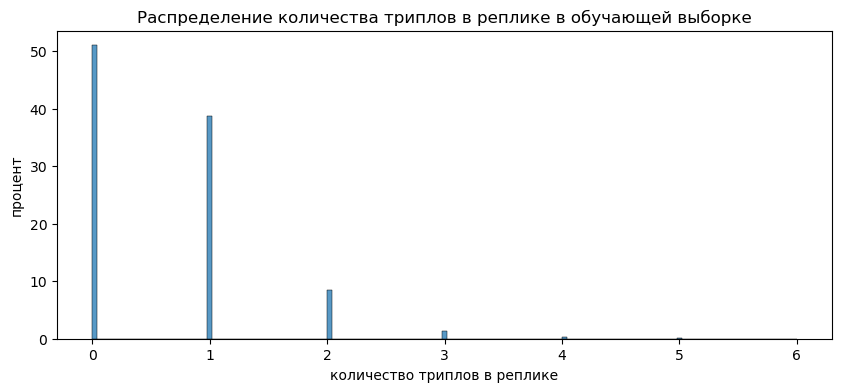

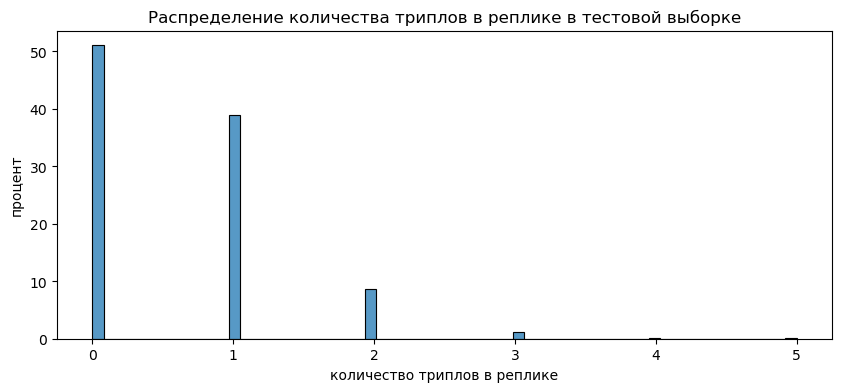

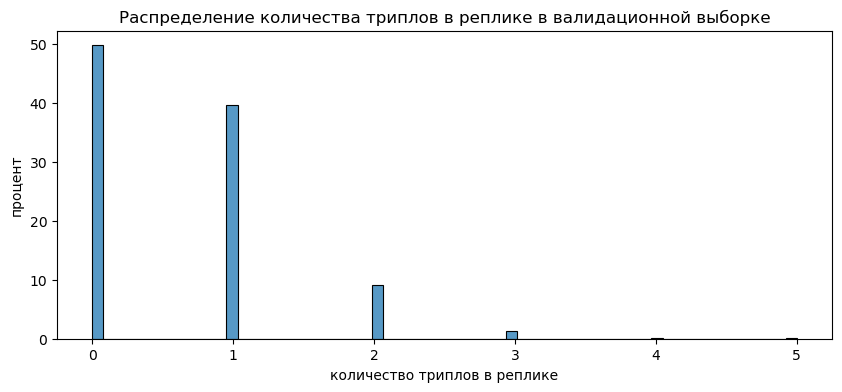

In [21]:
plot_triplet_cnt(train_df, "Распределение количества триплов в реплике в обучающей выборке")
plot_triplet_cnt(test_df, "Распределение количества триплов в реплике в тестовой выборке")
plot_triplet_cnt(val_df, "Распределение количества триплов в реплике в валидационной выборке")

## Triplet elements distribution

In [33]:
def extract_element(data_df: pd.DataFrame, element_type: str = "predicate") -> np.array:
    elements = []
    type2regex = {
        "subject": r"<subj> (.*) <rel>",
        "object": r"<obj> (.*)",
        "predicate": r"<rel> (.*) <obj>",
    }
    try:
        regex_pattern = type2regex[element_type]
    except KeyError:
        raise ValueError(
            f'Invalid type: {element_type}. Expected "object", "subject" or "predicate"'
        )

    def extend_elements(target_str: str) -> str:
        trg_splitted = target_str.split(";")
        for triplet in trg_splitted:
            elements.extend(re.findall(regex_pattern, triplet))
        return target_str

    _ = data_df["target"].apply(extend_elements)
    return np.array(elements)


def top_elements(data_df: pd.DataFrame, element_type: str = "predicate") -> np.array:
    all_elements = extract_element(train_df, element_type)
    unique_els, el_cnt = np.unique(all_elements, return_counts=True)
    top_idx = np.argsort(el_cnt)[::-1]
    return unique_els[top_idx], el_cnt[top_idx]


def print_top(data_df: pd.DataFrame, element_type: str = "predicate", top_k: int = 5):
    top_els, el_counts = top_elements(data_df, element_type)
    for subj, cnt in zip(top_els[:top_k], el_counts[:top_k]):
        print(f"{subj} --- {cnt}")
    print("*" * 20)
    for subj, cnt in zip(top_els[-top_k:], el_counts[-top_k:]):
        print(f"{subj} --- {cnt}")


def plot_element_distr(
    data_df: pd.DataFrame,
    element_type: str,
    title: str,
    figsize: tp.Tuple[int] = (10, 15),
):
    all_preds = extract_element(data_df, element_type=element_type)
    unique_preds, unique_cnt = np.unique(all_preds, return_counts=True)
    plt.figure(figsize=figsize)
    sns.barplot(x=unique_cnt, y=unique_preds)
    plt.title(title)
    # plt.title(label=f"{title}, {element_type}")
    # plt.xticks(rotation=90)
    plt.show()

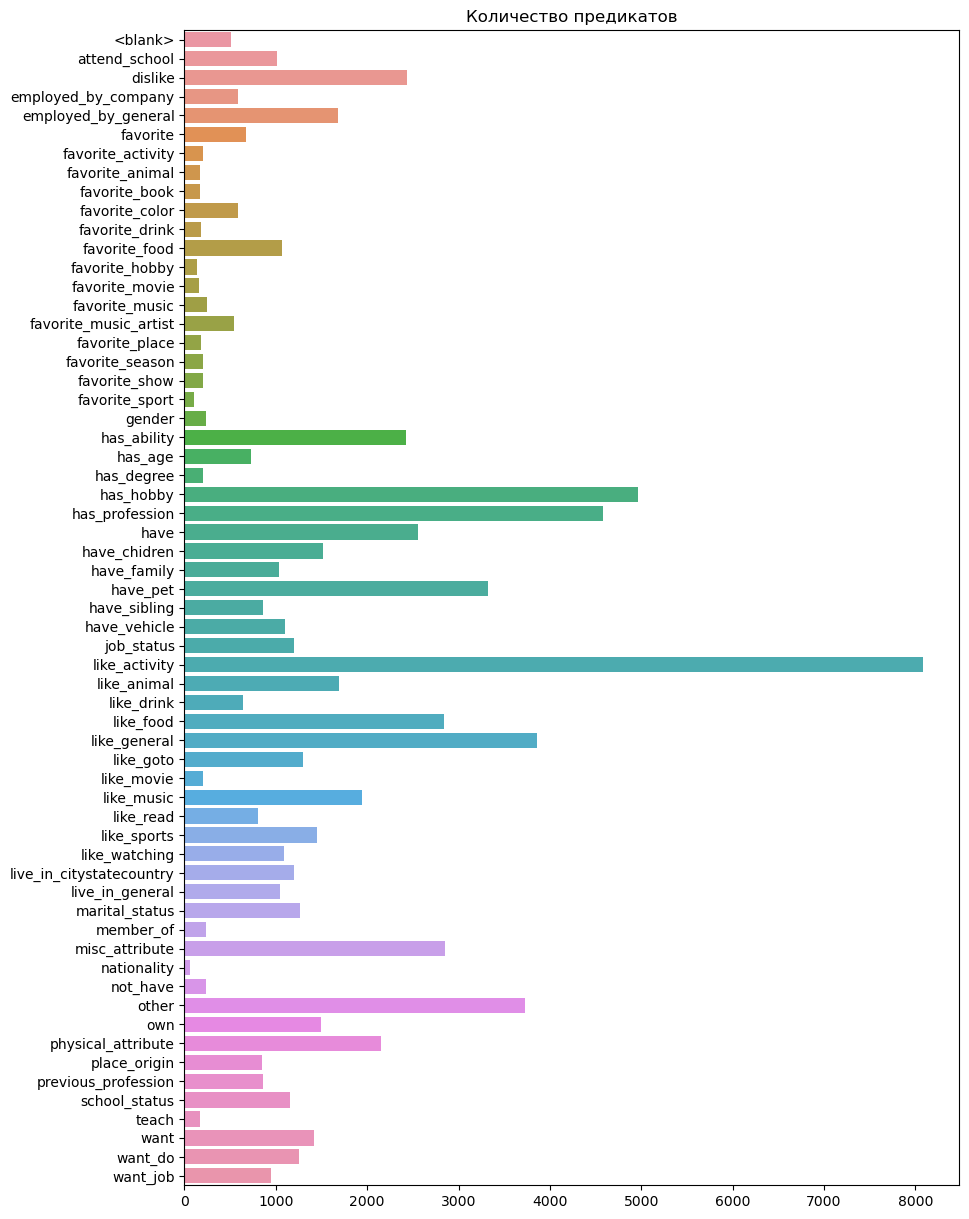

In [34]:
plot_element_distr(data_df=train_df, element_type="predicate", title="Количество предикатов")

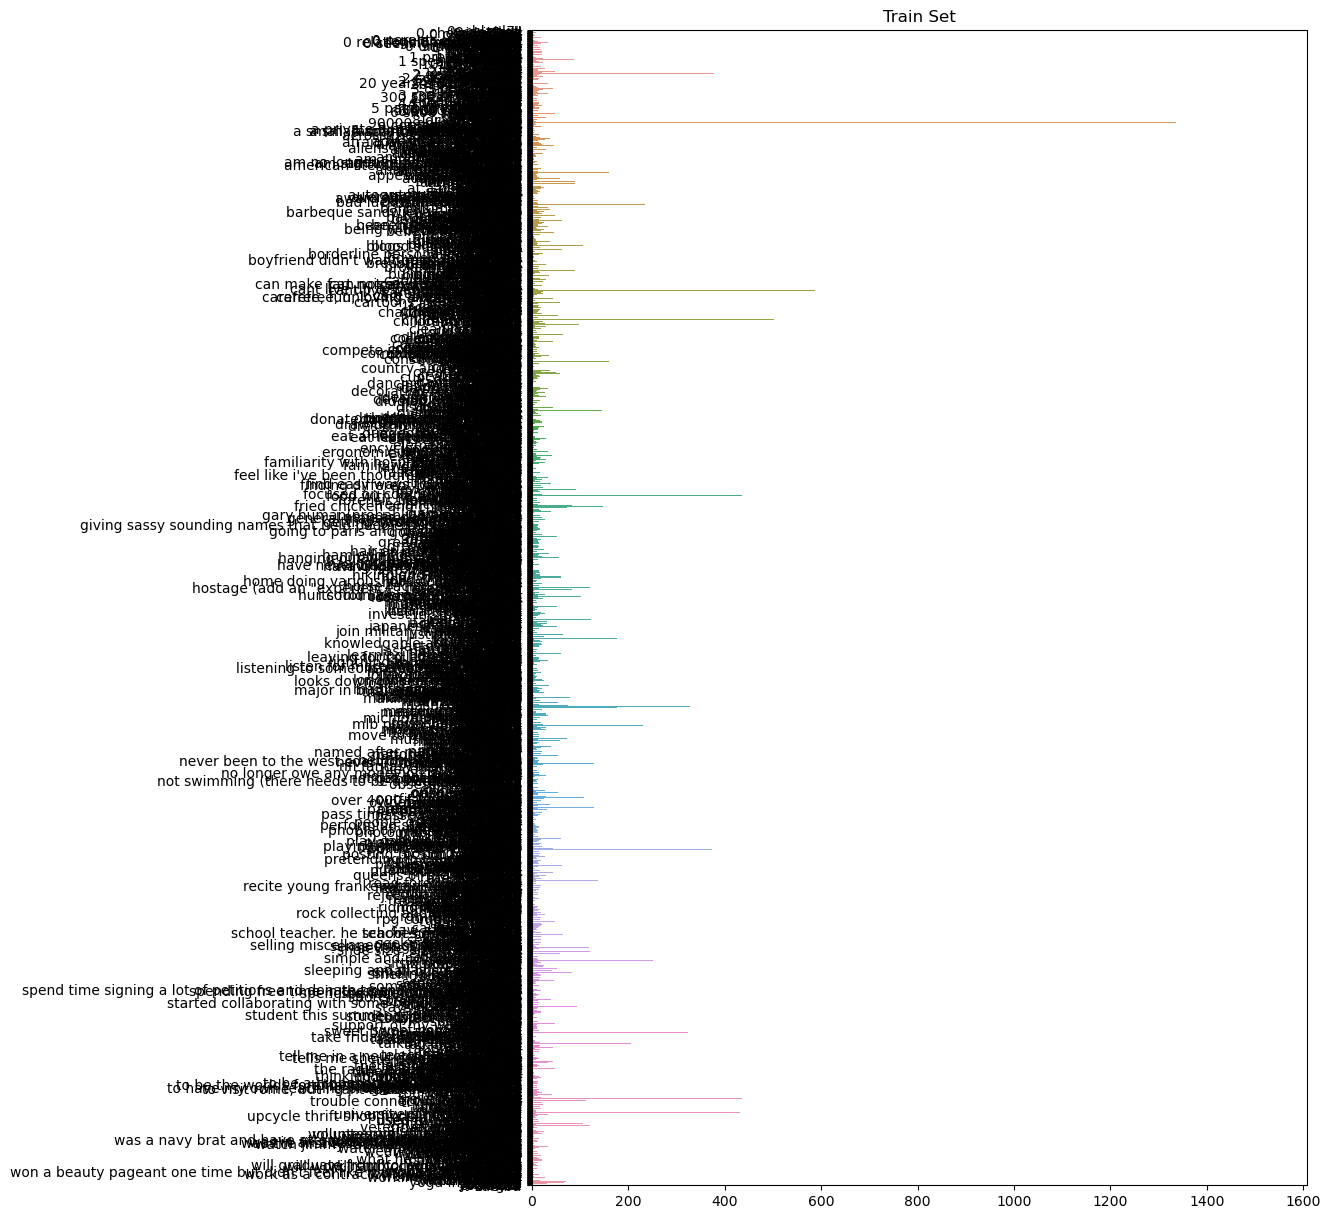

In [36]:
plot_element_distr(data_df=train_df, element_type="object", title="Train Set")

In [16]:
print_top(train_df, "subject", 10)

i --- 75202
my mother --- 988
my father --- 694
my --- 567
my brother --- 204
my parents --- 203
my husband --- 179
my family --- 177
my wife --- 156
parents --- 138
********************
my partner --- 1
my marriage --- 1
commitment --- 1
things --- 1
dude --- 1
the outcome --- 1
farms --- 1
my foster --- 1
kitten fluffy --- 1
my career --- 1


In [17]:
print_top(train_df, "object", 10)

dog --- 1530
<blank> --- 1336
cat --- 992
student --- 760
cooking --- 723
employed --- 716
teacher --- 710
play instrument --- 704
reading --- 671
travel --- 666
********************
hard time --- 1
sense things others can not --- 1
hard --- 1
being with freezing water --- 1
hair is long --- 1
grunge --- 1
group --- 1
5 pets --- 1
significant other --- 1
carriage --- 1


In [18]:
gc.collect()

56483